# Creating Constrained Expressions
Constrained expressions are the foundation of TFC. Hence, the TFC module provides a symbolic solver to help users create constrained expressions for the constraints they care about. The algorithm used in this solver is shown at 26:13 of [this video](https://www.youtube.com/watch?v=uisOZVBHA2U&t=1573s).

The description of this solver uses some jargon from TFC. Brief descriptions are provided here for users unfamiliar with these terms; more detailed descriptions can be found in the TFC [mathematical documentation](https://github.com/leakec/tfc#mathematical-documentation).

## Univariate example
The best way to understand the constrained expression solver is via examples. Let's begin with a simple univariate example. Suppose one wants to create a constrained expression for the following constraints
$$u(0) = 2 \quad \text{and} \quad u_x(2) = 1$$
where $u_x$ represents the derivative of $u$ with respect to $x$.

TFC describes constraints with two pieces: (1) the constraint operator, denoted by $C_i$, and (2) the rest of the constraint, denoted by $\kappa_i$. The constraint operator is an operator that evaluates a function in the same way the dependent variable is evaluated in the constraint. For example, in the $u(0) = 2$ constraint, the constraint operator takes in a function and evaluates it at $x=0$; the same way $u$ is evaluated in the constraint. Let this constraint operator be the first one, then, for example, $C_1[g] = g(0)$. The $\kappa$ portion of this same constraint is simply $0$.

In order to define a constrained expression, one must define a set of support functions used in its derivation. These are a set of linearly independent functions that are capable of interpolating the constraints. For more info on support functions, see the [mathematical documentation](https://github.com/leakec/tfc#mathematical-documentation). 

Now, let's create the constraint solver for these constraints.

In [1]:
import sympy as sp
from tfc.utils import CeSolver

# Create symbols and functions used by the constraint solver
u = sp.Function("u")
x = sp.Symbol("x")
g = sp.Function("g")

# Constraint operators
C = [lambda u: u.subs(x,0), lambda u: sp.diff(u,x).subs(x,2)]

# Kappa values
kappa = [sp.re(2), sp.re(1)]

# Support functions
s = [sp.re(1), x]

# Constrained expression solver
cs = CeSolver(C, kappa, s, g(x))                                             

The constrained expression solver is initialized with the constraint operators, $\kappa$ values, support functions, and free function that will be used in the constrained expression. Once these have been specified, the user needs to merely call the `ce` property of the `CeSolver` to see the solved constrained expression. 

In [2]:
cs.ce

x*(1 - Subs(Derivative(g(x), x), x, 2)) - g(0) + g(x) + 2

The constrained expression solver comes with three printing options: (1) TFC printer, (2) pretty printer, (3) string. One can switch between them by changing the `print_type` property of the constrained expression solver like so:

In [3]:
cs.print_type = "tfc"

Unfortunately, the Jupyter Notebook environment does not work well with custom Sympy printers. Therefore, the input/output from a standard Python script is shown here to demonstrate the `tfc` and `str` printers. The output from the pretty printer is shown above. 
```python
>>> cs.print_type = "tfc"
>>> cs.ce
x*(1 - egrad(g,0)(2)) - g(0) + g(x) + 2
>>> cs.print_type = "str"
>>> cs.ce
x*(1 - Subs(Derivative(g(x), x), x, 2)) - g(0) + g(x) + 2
>>> cs.print_type = "latex"
x \left(1 - \left. \frac{d}{d x} g{\left(x \right)} \right|_{\substack{ x=2 }}\right) - g{\left(0 \right)} + g{\left(x \right)} + 2
```

The TFC printer is desgined to output things in a format that is close to what you will need when using them in the rest of the TFC module. However, this output is not perfect and will likely need some minor modifications before it is ready to be used. 
<div class="alert alert-block alert-warning">
<b>WARNING:</b> The TFC printer has some hacks especially when it comes to printing the "Subs" expression. Please copy and paste with care.
</div>

One can also change properties of the constrained expression solver and the output constrained expression will be changed accordingly. For instance, suppose one wants to use $cos(x)$ and $x^2$ as their support functions rather than $1$ and $x$. Then, they can simply do:

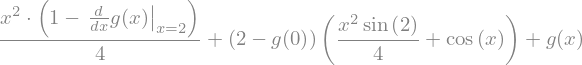

In [4]:
cs.s = [sp.cos(x), x**2]
cs.ce

One can always check that the current constrained expression in the constrained expression solver satisifies the cosntraints by calling the `checkCe()` function. This will return `True` if the constrained expression satisifies the cosntraints and `False` if it does not.

In [5]:
cs.checkCe()

True

One can also set their own constrained expression if they wish and check if it satisfies the constraints. Let's set one incorreclty on purpose to showcase the output of `checkCe` if the constrained expression is incorrect.

In [6]:
cs.ce = x*(1 - sp.diff(g(x),x).subs(x,2)) - g(0) + g(x) + 3
cs.checkCe()

Expected result of constraint 1 to be 2, but got 3.


False

The above warning let's us know that the first constraint yielded `3` rather than `2`. This is because of the purposeful mistake at the end of the constrained expression above. 

## Multivariate example
Now, let's try a more complicated example. Let's use the constraints from the tutorial on [PDEs](PDE.ipynb).
$$ u(0,y) = 0, \quad u(1,y) = \cos(y), \quad \text{and} \quad u(x,0) = u(x,2\pi)$$

Here, the constrained solver will be used twice. Once for the constraints on $x$ and again for the constraints on $y$.

In [7]:
# Create symbol for y
y = sp.Symbol("y")
u1 = sp.Function("u1")

# Constraints on x
Cx = [lambda u: u.subs(x,0), lambda u: u.subs(x,1)]
Kx = [sp.re(0), sp.cos(y)]
sx = [sp.re(1), x]
csx = CeSolver(Cx, Kx, sx, g(x,y))
cex = csx.ce

# Solve for the constrained expresssion that satisifes the y constraints
Cy = [lambda u: u.subs(y,0) - u.subs(y,sp.re(2*sp.pi))]
Ky = [sp.re(0)]
sy = [y]
csy = CeSolver(Cy, Ky, sy, u1(x,y))

print("u1(x,y,g(x,y)) = "+str(csx.ce))
print("u(x,y,u1(x,y,g(x,y))) = "+str(csy.ce))

u1(x,y,g(x,y)) = x*(-g(1, y) + cos(y)) - (1 - x)*g(0, y) + g(x, y)
u(x,y,u1(x,y,g(x,y))) = -y*(-u1(x, 0) + u1(x, 2*pi))/(2*pi) + u1(x, y)


This matches the constrained expression for the constraints given in the [PDE](PDE.ipynb) tutorial. Moreover, printing out the constrained expression using the TFC printer rather than the pretty printer yields:

In [8]:
# Creating the TfcPrinter manually is a hack. This is not normally needed. It is only needed in the
# Jupyter Notebook environment. Typically, one could just call csx.print_type = "tfc" and 
# csy.print_type = "tfc" and print out the constrained expressions in the same way shown above.
from tfc.utils.CeSolver import TfcPrinter
tfc_printer = TfcPrinter()
print("u1(x,y,g(x,y)) = " + tfc_printer.doprint(csx.ce))
print("u(x,y,u1(x,y,g(x,y))) = " + tfc_printer.doprint(csy.ce))

u1(x,y,g(x,y)) = x*(-g(1, y) + np.cos(y)) - (1 - x)*g(0, y) + g(x, y)
u(x,y,u1(x,y,g(x,y))) = -1/2*y*(-u1(x, 0) + u1(x, 2*pi))/np.pi + u1(x, y)


Notice that this is very similar, but not identical, to the constrained expression written in Python in the [PDE](PDE.ipynb) tutorial. The main thing that is missing is the the lack of `np.zeros_like(...)` and `np.ones_like(...)` calls that are needed for this to work with vectors. In addition, the [PDE](PDE.ipynb) tutorial uses `x[0]` and `x[1]` rather than `x` and `y`. 

## Complicated example
Time for a complicated example. Consider the constraints from Example 2.9 in Carl's dissertation
$$u(0,y) = \cos(\pi y), \quad \int_{-1}^2 u(1,y) \text{d}y = e, \quad u(x,1)-u(x,2) = -2,\\
    u(x,0)+v(x,0) = 5, \quad \text{and} \quad v(0,y) = 5-\cos(\pi y)$$

When solving multivariate constraints with integrals, one must be very careful with the switching functions; see Carl's dissertation in the [mathematical documentation](https://github.com/leakec/tfc#mathematical-documentation) for more details. The `CeSolver` class does not take this into account when solving for the constrained expression. In these cases, the user must set the switching functions manually. In this particular case, setting the support function to the appropriate switching function works, but this is not the case in general.

In [9]:
# Create symbols
u = sp.Function("u")
u1 = sp.Function("u1")
v = sp.Function("v")
v1 = sp.Function("v1")
gu = sp.Function("gu")
gv = sp.Function("gv")

x = sp.Symbol("x")
y = sp.Symbol("y")

# Constraints on x for u
Cux = [lambda u: u.subs(x,0), lambda u: sp.integrate(u.subs(x,1), (y,sp.re(-1), sp.re(2)))]
Kux = [sp.cos(sp.pi*y), sp.exp(1)]
sux = [sp.re(1), x]

cs_ux = CeSolver(Cux, Kux, sux, gu(x,y))
cs_ux.print_type = "pretty"
cs_ux_ce = cs_ux.ce

# Constraints on y for u
Cuy = [lambda u: u.subs(y,1) - u.subs(y,2)]
Kuy = [sp.re(-2)]
suy = [(1-2*y)/2]
cs_uy = CeSolver(Cuy, Kuy, suy, gu(x,y))
cs_uy.phi = sp.Matrix([(1-2*y)/2]) # Manually set phi due to integral constraint
cs_uy.print_type = "pretty"
cs_uy_ce = cs_uy.ce

# Constraints on x for v
Cvx = [lambda v: v.subs(x,0)]
Kvx = [5-sp.cos(sp.pi*y)]
svx = [sp.re(1)]

cs_vx = CeSolver(Cvx, Kvx, svx, gv(x,y))
cs_vx.print_type = "pretty"
cs_vx_ce = cs_vx.ce

# Constraints on y for v
Cvy = [lambda v: v.subs(y,0)]
Kvy = [5-u(x,0)]
svy = [sp.re(1)]

cs_vy = CeSolver(Cvy, Kvy, svy, v1(x,y))
cs_vy.print_type = "pretty"
cs_vy_ce = cs_vy.ce

# Show the result
print("u1(x,y,gu(x,y)) = " + str(cs_ux_ce))
print("u(x,y,u1(x,y,gu(x,y))) = " + str(cs_uy_ce))

print("v1(x,y,gu(x,y)) = " + str(cs_vx_ce))
print("v(x,y,u1(x,y,gu(x,y))) = " + str(cs_vy_ce))


u1(x,y,gu(x,y)) = x*(E - Integral(gu(1, y), (y, -1, 2)))/3 + (1 - x)*(-gu(0, y) + cos(pi*y)) + gu(x, y)
u(x,y,u1(x,y,gu(x,y))) = (1/2 - y)*(-gu(x, 1) + gu(x, 2) - 2) + gu(x, y)
v1(x,y,gu(x,y)) = -gv(0, y) + gv(x, y) - cos(pi*y) + 5
v(x,y,u1(x,y,gu(x,y))) = -u(x, 0) - v1(x, 0) + v1(x, y) + 5


These constrained expressions match the ones shown in Exmaple 2.9! However, in is always a good idea to check the full constrained expressions, i.e., make the subsitution so it is no longer written in recusrive form and call `checkCe()`.

In [10]:
# Check the full constrained expressions
cs_uy.g = cs_ux_ce
cs_u_full = cs_uy.ce

cs_vy.kappa = [5-cs_u_full.subs(y,0)]
cs_vy.g = cs_vx_ce
cs_v_full = cs_vy.ce

cs_ux.ce = cs_u_full
cs_uy.ce = cs_u_full
cs_vx.ce = cs_v_full
cs_vy.ce = cs_v_full

cs_ux.checkCe()
cs_uy.checkCe()
cs_vx.checkCe()
cs_vy.checkCe()

True

## Commmon gotchas
* Using an integer rather than `sp.re(...)`. `sp.re(...)` is necessary in most cases (especially in the $\kappa$ values). Otherwise, sympy will throw errors.
* The TFC printer is not designed to be a direct copy and paste. Rather, it gets one close to the form they will need to use with the rest of the TFC module. 
* The CeSolver does not consider other CeSolvers when solving multivariate constrained expressions. This is only a potential problem when integral constraints are included in a multivarite constrained expression, as the CeSolver will not take this into consideration when solving for the switching functions. This is a rare case, so it is unlikely to be a problem very often. 